In [1]:
import pandas as pd
import numpy as np
import ExMAS
import ExMAS.main
import ExMAS.utils
import pprint
import itertools
import csv
import os
import osmnx as ox
import dotmap
import sys
import random
import time
import math
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [16, 16]

import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.patches as mpatches
from cycler import cycler

import networkx as nx #graphs
cwd = os.getcwd()

from ExMAS.utils import inData as inData
from dotmap import DotMap


In [2]:
df1 = pd.read_csv('polygon9.csv') #population of area 9 (Bronowice)
df = df1.loc[df1.index.repeat(df1.ogolem)].reset_index(drop=True) #repeat Rows N times (equal "ogolem"): N Rows = N people 
params = ExMAS.utils.get_config('default_SUM.json') # load the default
params.city = 'Krakow, Poland'
params = ExMAS.utils.make_paths(params) # update file paths
inData = ExMAS.utils.load_G(inData, params, stats=True)  # download the graph

In [3]:
df

,Unnamed: 0,FID,x,y,adr_pelny,ogolem,inside_polygon
0,3748,3748,19.888952,50.096458,STAWOWA 156,51,True
1,3748,3748,19.888952,50.096458,STAWOWA 156,51,True
2,3748,3748,19.888952,50.096458,STAWOWA 156,51,True
3,3748,3748,19.888952,50.096458,STAWOWA 156,51,True
4,3748,3748,19.888952,50.096458,STAWOWA 156,51,True
...,...,...,...,...,...,...,...
3997,46951,46951,19.882419,50.096761,STAWOWA 187E,1,True
3998,46952,46952,19.882340,50.096783,STAWOWA 187F,1,True
3999,47521,47521,19.889906,50.087955,ELIASZA RADZIKOWSKIEGO 152,1,True
4000,47523,47523,19.886080,50.094938,SOSNOWIECKA 19B,1,True


In [4]:
def run_ExMAS_SUM(inData, params, hub, frac, repl):

    params.nP = int(frac * len(df))
    sample = df.sample(n = int(frac * len(df)), replace=False, weights=None, random_state=None, axis=None) # demand of RP=frac*population
    sample['origin'] = sample.apply(lambda row:  ox.get_nearest_node(inData.G, (row['y'], row['x'])), axis = 1) 
    inData = ExMAS.utils.generate_demand(inData, params) #generate trip requests

    my_requests = inData.requests
    my_requests.destination = hub[1]
    my_requests["origin"] = sample.origin.values
    my_requests['dist'] = my_requests.apply(lambda request: inData.skim.loc[request.origin, request.destination], axis=1)
    my_requests['ttrav'] = my_requests.apply(lambda request: pd.Timedelta(request.dist, 's').floor('s'), axis=1)
    my_requests.tarr = [request.treq + request.ttrav for _, request in my_requests.iterrows()]
    my_requests = inData.requests
    inData.requests = my_requests
    # inData.requests.to_csv("check.csv")
    inData = ExMAS.main(inData, params)
    inData.sblts.requests.to_csv("requests.csv")
    inData.sblts.rides.to_csv("rides.csv")
    KPIs = inData.sblts.res.to_frame()[:23]
    # KPIs['description']  = ExMAS.utils.KPIs_descriptions
    KPIs.columns = ['KPI']
    KPIs
    KPIs.to_csv(f'res/9/KPI_{hub[0]}_{frac}_{repl}.csv') #res/
    return KPIs

params.shared_discount = 0.2
params.simTime = 0.5
params.t0 = params.t0.replace(hour=8)
params.speeds.ride = 6
params.VoT = 0.003
params.pax_delay = 15
params.max_degree = 4
params.price = 1.5
results = dict()
 
#    hubs   
hubs = [('hub1', ox.get_nearest_node(inData.G,[50.08179,19.88192])),
        ('hub2', ox.get_nearest_node(inData.G,[50.081331,19.889698])),
        ('hub3', ox.get_nearest_node(inData.G,[50.083524,19.859835]))]

for frac in  [0.01]: #list of frac 0.00025, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001, 0.0015, 0.002, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03
    for h in hubs:
        for i in range(1): 
            print(h[0], frac, i + 1)
            results[frac] = run_ExMAS_SUM(inData, params, h, frac, i)

hub1 0.01 1
18-06-24 13:15:37-INFO-Initializing pairwise trip shareability between 40 and 40 trips.
18-06-24 13:15:37-INFO-creating combinations
18-06-24 13:15:37-INFO-1560	 nR*(nR-1)
18-06-24 13:15:37-INFO-Reduction of feasible pairs by 97.31%
18-06-24 13:15:37-INFO-Degree 2 	Completed
18-06-24 13:15:37-INFO-trips to extend at degree 2 : 93
18-06-24 13:15:37-INFO-At degree 2 feasible extensions found out of 12 searched
18-06-24 13:15:37-INFO-Degree 3 	Completed
18-06-24 13:15:37-INFO-trips to extend at degree 3 : 12
18-06-24 13:15:37-INFO-At degree 3 feasible extensions found out of 2 searched
18-06-24 13:15:37-INFO-Degree 4 	Completed
18-06-24 13:15:37-INFO-Max degree reached 4
18-06-24 13:15:37-INFO-Trips still possible to extend at degree 4 : 2
18-06-24 13:15:37-INFO-Matching 40 trips to 147 rides in order to minimize u_veh
18-06-24 13:15:37-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,016 
reduced by matching to:                9,886
18-06-24 13:15:37-

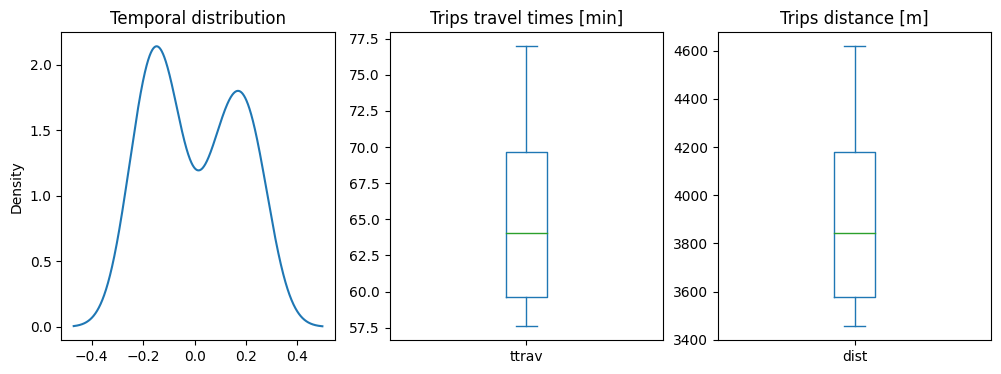

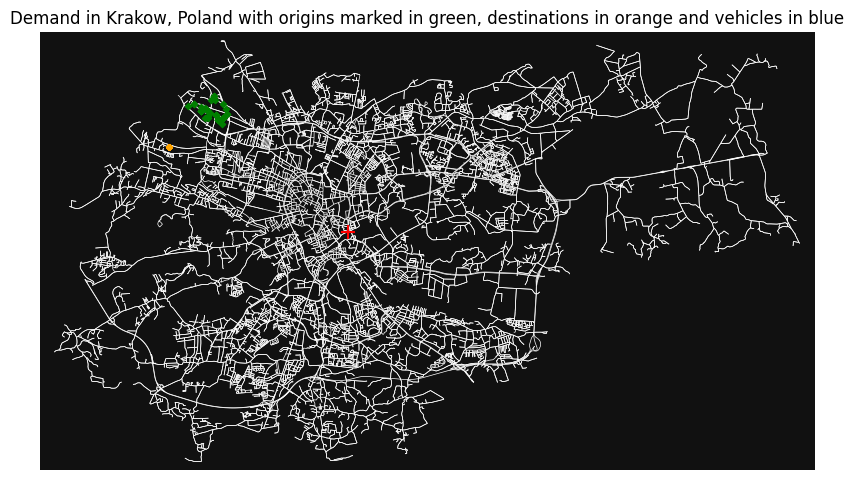

In [5]:
ExMAS.utils.plot_demand(inData, params)

### plotting

In [6]:
dfT91 = pd.read_csv('res/9/resultT9_D00025-01(20).csv', index_col=0) # KPI for 20 replications for demand fraction range 0.00025-0.01 for area 9, discount 0.2

dfT91['del_VehHourTrav']=abs(dfT91['VehHourTrav']-dfT91['VehHourTrav_ns'])/dfT91['VehHourTrav_ns']           # KPI1: vehicle hours reduction
dfT91['del_PassUtility']=abs((dfT91['PassUtility']-dfT91['PassUtility_ns'])/dfT91['PassUtility_ns'])         # KPI2: travellers utility gains
dfT91['Occupancy']=dfT91['PassHourTrav']/dfT91['VehHourTrav']                                                # KPI4: occupancy
dfT91['del_PassHourTrav']=abs((dfT91['PassHourTrav']-dfT91['PassHourTrav_ns'])/dfT91['PassHourTrav_ns'])     # KPI5: passenger hours increase
dfT91['del_fleet_size']=abs((dfT91['fleet_size_shared']-dfT91['fleet_size_nonshared'])/dfT91['fleet_size_nonshared'])  # KPI6: potential fleet size reduction                  
                  
dfT91['frac'] = round((dfT91['nR'] / 4002),4) #4002 - population of area 9
dfT91['VehHourTrav_average'] =dfT91['VehHourTrav'] / dfT91['nR'] 
dfT91['PassHourTrav_average'] =dfT91['PassHourTrav'] / dfT91['nR'] 

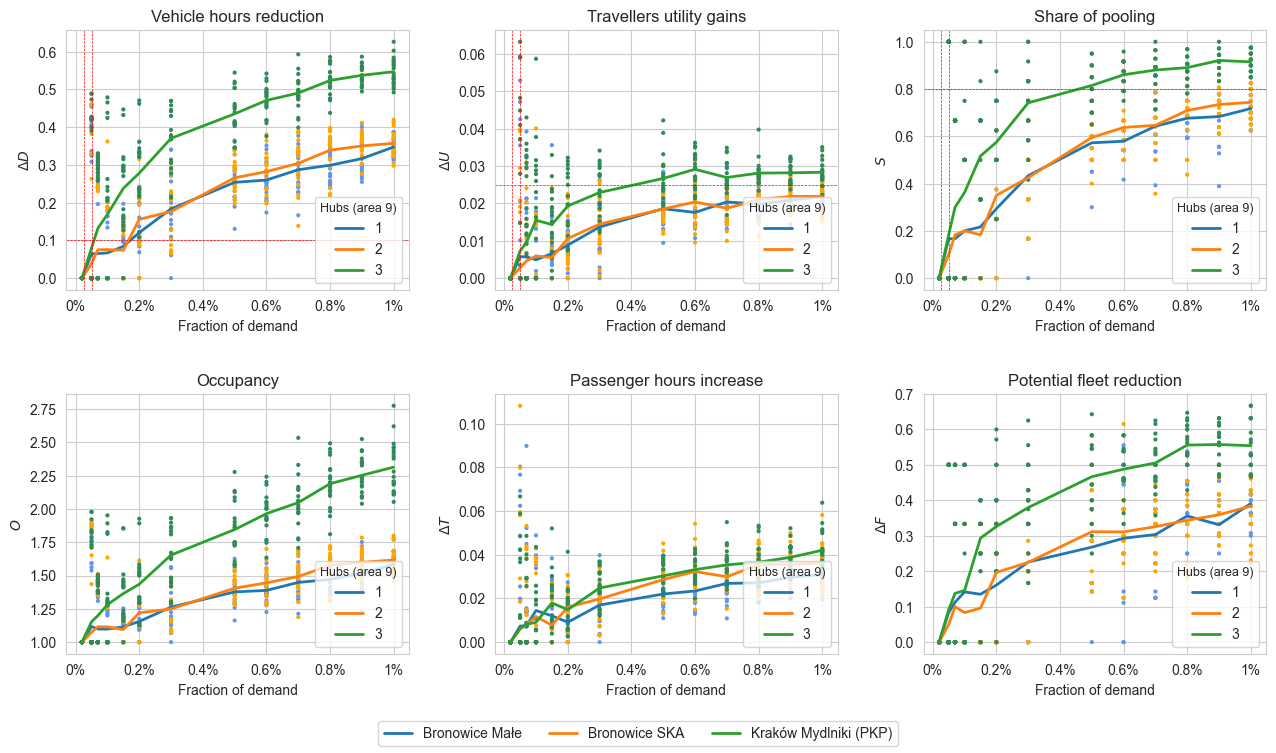

In [8]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(2,3, figsize = (12,8))
axes = axes.flatten()

ax=axes[0]
for f in dfT91.hub.unique():
    to_plot = dfT91[(dfT91.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_VehHourTrav'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT91[(dfT91.hub == f)].groupby(dfT91.frac).del_VehHourTrav.mean().plot(ax = ax, label = f, lw = 2)
ax.axhline(y=0.1, color='r', linestyle='--', lw=0.5)
ax.axvline(x=0.0005, color='r', ls='--', lw=0.5)
ax.axvline(x=0.00025, color='r', ls='--', lw=0.5)
ax.set_title("Vehicle hours reduction", fontsize=12, fontweight='normal')
ax.legend(title='Hubs (area 9)', loc='lower right', title_fontsize='9')
ax.set_ylabel("$\Delta D$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )

ax=axes[1]
for f in dfT91.hub.unique():
    to_plot = dfT91[(dfT91.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_PassUtility'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT91[(dfT91.hub == f)].groupby(dfT91.frac).del_PassUtility.mean().plot(ax = ax, label = f, lw = 2)
ax.axhline(y=0.025, color='r', linestyle='--', lw=0.5)
ax.axvline(x=0.0005, color='r', ls='--', lw=0.5)
ax.axvline(x=0.00025, color='r', ls='--', lw=0.5)
ax.set_title("Travellers utility gains", fontsize=12, fontweight='normal')
ax.legend(title='Hubs (area 9)', loc='lower right', title_fontsize='9')
ax.set_ylabel("$\Delta U$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )

ax=axes[2]
for f in dfT91.hub.unique():
    to_plot = dfT91[(dfT91.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['shared_ratio'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT91[(dfT91.hub == f)].groupby(dfT91.frac).shared_ratio.mean().plot(ax = ax, label = f, lw = 2)
ax.axhline(y=0.8, color='r', linestyle='--', lw=0.5)
ax.axvline(x=0.0005, color='r', ls='--', lw=0.5)
ax.axvline(x=0.00025, color='r', ls='--', lw=0.5)
ax.set_title("Share of pooling", fontsize=12, fontweight='normal')
ax.legend(title='Hubs (area 9)', loc='lower right', title_fontsize='9')
ax.set_ylabel("$S$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )

ax=axes[3]
for f in dfT91.hub.unique():
    to_plot = dfT91[(dfT91.hub == f)]
    ax.scatter(x=to_plot['frac'], y=to_plot['Occupancy'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT91[(dfT91.hub == f)].groupby(dfT91.frac).Occupancy.mean().plot(ax = ax, label = f, lw = 2)
ax.set_title("Occupancy", fontsize=12, fontweight='normal')
ax.legend(title='Hubs (area 9)', loc='lower right', title_fontsize='9')
ax.set_ylabel("$O$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )

ax=axes[4]
for f in dfT91.hub.unique():
    to_plot = dfT91[(dfT91.hub == f)]
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_PassHourTrav'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
    dfT91[(dfT91.hub == f)].groupby(dfT91.frac).del_PassHourTrav.mean().plot(ax = ax, label = f, lw = 2)
ax.set_title("Passenger hours increase", fontsize=12, fontweight='normal')
ax.legend(title='Hubs (area 9)', loc='lower right', title_fontsize='9')
ax.set_ylabel("$\Delta T$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )

ax=axes[5]
for f in dfT91.hub.unique():
    to_plot = dfT91[(dfT91.hub == f)]
    dfT91[(dfT91.hub == f)].groupby(dfT91.frac).del_fleet_size.mean().plot(ax = ax, label = f, lw = 2)
    colors = {1:'cornflowerblue', 2:'orange', 3: 'seagreen'}
    ax.scatter(x=to_plot['frac'], y=to_plot['del_fleet_size'], c=to_plot['hub'].map(colors), s = 4, alpha=1)
ax.set_title("Potential fleet reduction", fontsize=12, fontweight='normal')
ax.legend(title='Hubs (area 9)', loc='lower right', title_fontsize='9')
ax.set_ylabel("$\Delta F$", fontsize=10)
ax.set_xlabel("Fraction of demand", fontsize=10)
ax.set_xticklabels( ('0','0%','0.2%','0.4%','0.6%','0.8%','1%') )

plt.subplots_adjust(left=0,
                    bottom=0.12, 
                    right=1, 
                    top=0.9, 
                    wspace=0.25, 
                    hspace=0.4)


labels = ['Bronowice Małe', 
'Bronowice SKA', 
'Kraków Mydlniki (PKP)']

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc='lower center', ncol=3)